# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random using Vrard model.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [3]:
#import output data
nstars = 50
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

The model used will be that described in Vrard 2014:

$$\nu(n)=\left(n+\epsilon+\frac{\alpha}{2}\left(n_{max}-n\right)^2+\frac{\mathcal{A}\mathcal{G}}{2\pi}sin\left(\frac{2\pi\left(n-n_{max}\right)}{\mathcal{G}}+\phi\right)\right) \langle\Delta\nu\rangle$$

where is found from $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [4]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit '+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)
        
    plt.xlabel(r'Frequency modulo ($\mu Hz$)')
    plt.ylabel(r'Frequency ($\mu Hz$)')
    plt.legend()

In [5]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi):
    freqs = (n + epsilon + alpha/2 * (nmax - n)**2 + A*G/(2*np.pi) * np.sin((2*np.pi*(n-nmax))/G + phi))*dnu #* np.exp(-n/tau);
    return freqs

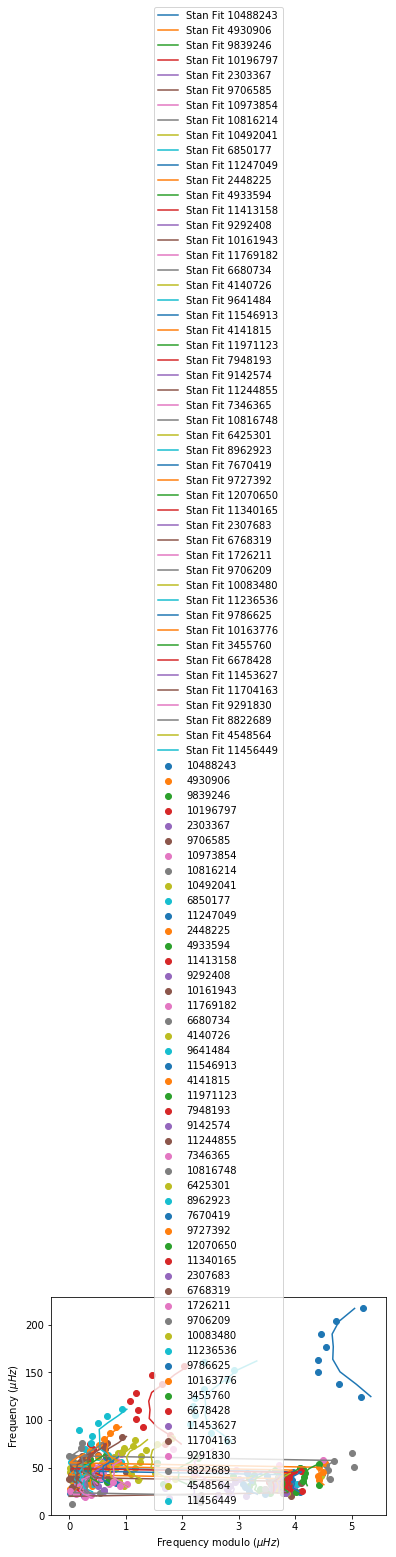

In [6]:
for i in IDs:
    #values from Vrard
    dnu_avg = np.mean(modes[str(i)].dnu)
    n = modes[str(i)].n
    #epsilon = 0.601 + 0.632*np.log(dnu_avg)
    epsilon = np.median((modes[str(i)].f0 % dnu_avg) / dnu_avg)
    numax_obs = float(stardat.loc[stardat['ID'] == i].Numax)
    nmax = numax_obs/dnu_avg - epsilon
    alpha = 0.015*dnu_avg**(-0.32)
    A = 0.06*dnu_avg**(-0.88) 
    G = 3.08
    #tau = 8
    phi = 1.71
    f = model(n, dnu_avg, nmax, epsilon, alpha, A, G, phi)
    echelle(stardat, modes, i, True, f, dnu_avg)
    

In [7]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [8]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real nmax;
    real epsilon;
    real alpha;
    real<lower = 0> A;
    real<lower = 0> G;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    //real<lower = 0> tau;
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon + (alpha/2) * (nmax - n[i])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[i]-nmax))/G + phi))*dnu;
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(epsA + epsB*log(dnu), 0.5);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(10, 4);
    alpha ~ lognormal(log(alA*dnu^(-alB)), 0.3);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    A ~ lognormal(log(AA*dnu^(-AB)), 0.4);
    //A ~ lognormal(log(0.06*dnu^(-0.88)), 0.4);
    G ~ normal(3.08, 0.65);
    // tau ~ normal(50, 10);
    epsA ~ normal(0.601, 0.080);
    epsB ~ normal(0.632, 0.080);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon + (alpha/2) * (nmax - n[j])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[j]-nmax))/G + phi))*dnu;
        }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0dda3e4b285fc6a0f5224af403aead82 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpdxipuw99/stanfit4anon_model_0dda3e4b285fc6a0f5224af403aead82_450298956997676197.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    #epsilon_obs = 0.601 + 0.632*np.log(dnu_obs)
    alpha_obs = 0.015*dnu_obs**(-0.32)
    A_obs = 0.06*dnu_obs**(-0.88)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'alpha': alpha_obs, 'A': A_obs,
             'G': 3, 'phi': 1.6}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'alpha': fit['alpha'], 'A': fit['A'], 'G': fit['G'], 'phi': fit['phi'], 
                           'epsA': fit['epsA'], 'epsB': fit['epsB'], 'alA': fit['alA'], 'alB': fit['alB'],
                           'AA': fit['AA'], 'AB': fit['AB']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [10]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 10488243
Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.13  5.7e-5 4.1e-3   4.12   4.13   4.13   4.14   4.14   5177    1.0
nmax      7.85  4.5e-3   0.31   7.29   7.64   7.83   8.02   8.51   4570    1.0
epsilon   0.94  1.3e-4 9.3e-3   0.92   0.94   0.94   0.95   0.96   5174    1.0
alpha   8.6e-3  2.3e-5 2.1e-3 4.7e-3 7.1e-3 8.5e-3 9.9e-3   0.01   8107    1.0
A         0.03  8.1e-5 7.6e-3   0.01   0.02   0.03   0.03   0.04   8873    1.0
G         2.95  4.6e-3   0.35   2.27   2.74   2.93   3.16    3.7   5980    1.0
phi        0.7    0.01   0.74  -0.71   0.21   0.67   1.14   2.21   5079    1.0
epsA      0.59  7.6e-4   0.08   0.43   0.53   0.59   0.64   0.74  10627    1.0
epsB      0.61  7.7e-4   0.08   0.46   0.56   0.61   0.66   0.76  10423    1.0
alA   

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.97  4.9e-5 3.9e-3   3.96   3.97   3.97   3.97   3.98   6446    1.0
nmax      6.31  1.5e-3   0.12   6.08   6.23   6.31   6.39   6.55   5882    1.0
epsilon   0.96  9.5e-5 7.6e-3   0.94   0.95   0.96   0.96   0.97   6298    1.0
alpha     0.01  1.6e-5 2.0e-3   0.01   0.01   0.01   0.02   0.02  15165    1.0
A         0.06  6.9e-5 5.9e-3   0.05   0.06   0.06   0.07   0.07   7449    1.0
G         2.42  2.4e-3    0.1   2.22   2.37   2.43   2.48   2.58   1746    1.0
phi      -0.68  4.6e-3   0.36  -1.38  -0.92  -0.68  -0.44   0.04   6079    1.0
epsA      0.59  6.7e-4   0.08   0.43   0.53   0.59   0.64   0.74  14591    1.0
epsB      0.61  6.3e-4   0.08   0.46   0.56   0.61   0.67   0.77  15265    1.0
alA       0.02  3.3e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.65  6.6e-5 4.6e-3   4.64   4.65   4.65   4.65   4.66   4904    1.0
nmax      10.1  1.5e-3    0.1   9.92  10.03   10.1  10.17  10.32   4401    1.0
epsilon 2.9e-3  1.6e-4   0.01  -0.02-4.3e-3 2.9e-3   0.01   0.02   4540    1.0
alpha     0.02  3.6e-5 2.5e-3   0.01   0.02   0.02   0.02   0.02   4757    1.0
A         0.03  5.5e-5 4.7e-3   0.02   0.03   0.03   0.03   0.04   7264    1.0
G         3.81  4.1e-3    0.3   3.29   3.59   3.78   3.99   4.45   5224    1.0
phi       2.02  3.5e-3   0.24   1.59   1.86   2.01   2.17   2.51   4510    1.0
epsA      0.56  8.1e-4   0.08   0.41   0.51   0.56   0.62   0.72   9357    1.0
epsB      0.58  8.0e-4   0.08   0.43   0.52   0.58   0.63   0.73   9384    1.0
alA       0.02  3.9e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.96  7.2e-5 5.0e-3   4.95   4.96   4.96   4.97   4.97   4945    1.0
nmax     10.85  2.9e-3    0.2  10.44  10.73  10.85  10.98  11.23   4714    1.0
epsilon   0.04  1.6e-4   0.01   0.02   0.04   0.04   0.05   0.07   4854    1.0
alpha   8.8e-3  1.7e-5 1.5e-3 5.6e-3 7.8e-3 8.8e-3 9.8e-3   0.01   7877    1.0
A         0.01  4.4e-5 4.0e-3 7.7e-3   0.01   0.01   0.02   0.02   8052    1.0
G         3.98    0.01   0.51   2.95   3.69   3.99   4.29   4.94   1889    1.0
phi      -0.92    0.02   0.57  -1.86  -1.25  -0.95  -0.64   0.14   1354    1.0
epsA      0.56  7.1e-4   0.08   0.41   0.51   0.56   0.62   0.72  12818    1.0
epsB      0.57  7.0e-4   0.08   0.42   0.52   0.57   0.63   0.73  12495    1.0
alA       0.02  3.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       2.35  2.5e-5 2.3e-3   2.35   2.35   2.35   2.36   2.36   8443    1.0
nmax      7.32  2.0e-3   0.16    7.0   7.21   7.32   7.42   7.64   6283    1.0
epsilon  -0.03  9.1e-5 7.8e-3  -0.05  -0.04  -0.03  -0.03  -0.01   7435    1.0
alpha     0.01  4.1e-5 3.4e-3 8.1e-3   0.01   0.02   0.02   0.02   6947    1.0
A         0.03  7.6e-5 5.5e-3   0.02   0.03   0.03   0.04   0.04   5323    1.0
G         3.16  6.5e-3   0.37   2.56   2.92   3.13   3.37   3.98   3163    1.0
phi       5.64  4.5e-3   0.37   4.81    5.4   5.67   5.92   6.23   6676    1.0
epsA      0.57  6.8e-4   0.08   0.42   0.52   0.57   0.62   0.73  13658    1.0
epsB      0.61  6.7e-4   0.08   0.45   0.55   0.61   0.66   0.76  13860    1.0
alA       0.02  3.9e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.59  1.9e-3 5.3e-3   4.58   4.59   4.59   4.59    4.6      8   1.17
nmax       9.4    0.09   0.18   9.07   9.25    9.4   9.53   9.75      4   1.37
epsilon  -0.03  4.3e-3   0.01  -0.05  -0.04  -0.03  -0.03  -0.01      7    1.2
alpha     0.01  1.4e-4 9.4e-4 9.8e-3   0.01   0.01   0.01   0.01     47   1.03
A         0.03  5.5e-3   0.01   0.01   0.02   0.03   0.03   0.06      5   1.35
G         2.82    0.44   0.72   1.44   2.88   3.11   3.27   3.57      3    2.3
phi       3.26    1.81   2.59   0.17   0.71   2.65    6.1   6.27      2   7.26
epsA      0.56  7.8e-4   0.08   0.41   0.51   0.56   0.62   0.72  10329    1.0
epsB      0.57  7.4e-4   0.08   0.42   0.52   0.57   0.63   0.73  11276    1.0
alA       0.02  3.5e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.24  5.4e-5 4.3e-3   4.23   4.23   4.24   4.24   4.24   6293    1.0
nmax      8.36  1.3e-3    0.1   8.17    8.3   8.36   8.43   8.56   5761    1.0
epsilon  -0.01  1.1e-4 8.9e-3  -0.03  -0.02  -0.01-8.1e-3 3.1e-3   6235    1.0
alpha     0.02  1.7e-5 1.8e-3   0.01   0.02   0.02   0.02   0.02  11704    1.0
A         0.03  7.6e-5 6.6e-3   0.02   0.02   0.03   0.03   0.04   7410    1.0
G         2.66  5.1e-3   0.23   2.25   2.55   2.66   2.77   3.08   1984    1.0
phi      -0.52  4.1e-3   0.32  -1.12  -0.73  -0.53  -0.31   0.15   6132    1.0
epsA      0.56  7.3e-4   0.08   0.41   0.51   0.56   0.62   0.72  11580    1.0
epsB      0.58  7.3e-4   0.08   0.43   0.53   0.58   0.63   0.73  11302    1.0
alA       0.02  3.2e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu        6.9  1.1e-4 6.9e-3   6.89   6.89    6.9    6.9   6.91   3958    1.0
nmax     11.86  2.3e-3   0.14  11.59  11.76  11.85  11.95  12.15   3748    1.0
epsilon   0.05  2.0e-4   0.01   0.02   0.04   0.05   0.05   0.07   3815    1.0
alpha     0.01  8.0e-6 9.1e-4 8.7e-3 9.9e-3   0.01   0.01   0.01  13034    1.0
A         0.03  8.2e-5 7.0e-3   0.02   0.03   0.03   0.04   0.05   7166    1.0
G         3.04  1.5e-3   0.13    2.8   2.96   3.04   3.12    3.3   6629    1.0
phi       2.15  5.8e-3   0.36   1.46    1.9   2.14    2.4   2.87   3905    1.0
epsA      0.56  8.1e-4   0.08    0.4   0.51   0.56   0.61   0.72   9872    1.0
epsB      0.55  8.1e-4   0.08    0.4    0.5   0.55    0.6   0.71   9068    1.0
alA       0.02  3.7e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.28  6.6e-5 4.3e-3   4.27   4.27   4.28   4.28   4.29   4265    1.0
nmax      8.93  1.4e-3   0.09   8.76   8.87   8.93   8.99   9.11   4130    1.0
epsilon   0.07  1.4e-4 9.2e-3   0.05   0.07   0.07   0.08   0.09   4166    1.0
alpha     0.02  1.1e-5 1.3e-3   0.01   0.02   0.02   0.02   0.02  16091    1.0
A         0.04  5.8e-5 5.1e-3   0.03   0.04   0.04   0.05   0.05   7801    1.0
G          2.6  1.1e-3    0.1   2.42   2.54    2.6   2.66    2.8   7873    1.0
phi       0.66  3.7e-3   0.25   0.19    0.5   0.66   0.83   1.15   4348    1.0
epsA      0.57  8.1e-4   0.08   0.42   0.52   0.57   0.62   0.72   9434    1.0
epsB      0.58  7.9e-4   0.08   0.43   0.53   0.58   0.63   0.74   9661    1.0
alA       0.02  3.5e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu        4.0  4.5e-5 4.0e-3   3.99    4.0    4.0    4.0   4.01   7720    1.0
nmax      7.46  1.9e-3   0.16   7.17   7.36   7.46   7.56   7.78   6909    1.0
epsilon   0.91  1.2e-4 9.6e-3   0.89    0.9   0.91   0.92   0.93   6725    1.0
alpha     0.01  3.0e-5 2.8e-3 9.6e-3   0.01   0.01   0.02   0.02   8641    1.0
A         0.02  6.5e-5 6.2e-3   0.01   0.02   0.02   0.03   0.03   9255    1.0
G         3.32  8.1e-3   0.54    2.2   3.01   3.33   3.66   4.37   4375    1.0
phi       0.84    0.01   0.78  -0.33   0.34   0.73   1.18   2.81   3507    1.0
epsA      0.59  7.2e-4   0.08   0.43   0.53   0.59   0.64   0.75  12136    1.0
epsB      0.61  6.9e-4   0.08   0.46   0.56   0.61   0.66   0.76  12353    1.0
alA       0.02  3.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.85  7.8e-5 4.8e-3   4.84   4.85   4.85   4.85   4.86   3886    1.0
nmax     10.02  1.7e-3   0.11   9.83   9.95  10.02   10.1  10.26   4195    1.0
epsilon   0.06  1.6e-4   0.01   0.04   0.05   0.06   0.06   0.08   3973    1.0
alpha     0.02  2.2e-5 1.7e-3   0.01   0.01   0.02   0.02   0.02   5991    1.0
A         0.02  3.9e-5 3.7e-3   0.01   0.02   0.02   0.02   0.03   9263    1.0
G         3.47  4.3e-3   0.33   2.92   3.24   3.44   3.68   4.19   5850    1.0
phi       1.67  4.5e-3   0.31   1.09   1.46   1.66   1.86   2.32   4773    1.0
epsA      0.56  7.5e-4   0.08   0.41   0.51   0.57   0.62   0.72  11230    1.0
epsB      0.57  7.6e-4   0.08   0.42   0.52   0.57   0.63   0.73  10647    1.0
alA       0.02  3.7e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.33  5.6e-5 4.4e-3   4.32   4.33   4.33   4.33   4.34   6167    1.0
nmax      9.61  3.7e-3   0.24   9.08   9.47   9.63   9.76  10.03   4305    1.0
epsilon   0.15  1.4e-4   0.01   0.13   0.14   0.15   0.15   0.17   6003    1.0
alpha     0.01  2.6e-5 2.2e-3 7.2e-3   0.01   0.01   0.01   0.02   6990    1.0
A         0.03  5.4e-5 5.6e-3   0.02   0.02   0.03   0.03   0.04  10897    1.0
G         3.86  4.2e-3   0.39   3.21   3.58   3.84   4.11   4.71   8515    1.0
phi      -1.08  7.3e-3   0.49  -2.14  -1.37  -1.04  -0.75  -0.22   4519    1.0
epsA      0.57  6.7e-4   0.08   0.42   0.52   0.57   0.62   0.72  13398    1.0
epsB      0.58  6.6e-4   0.08   0.43   0.53   0.58   0.64   0.73  13485    1.0
alA       0.02  3.7e

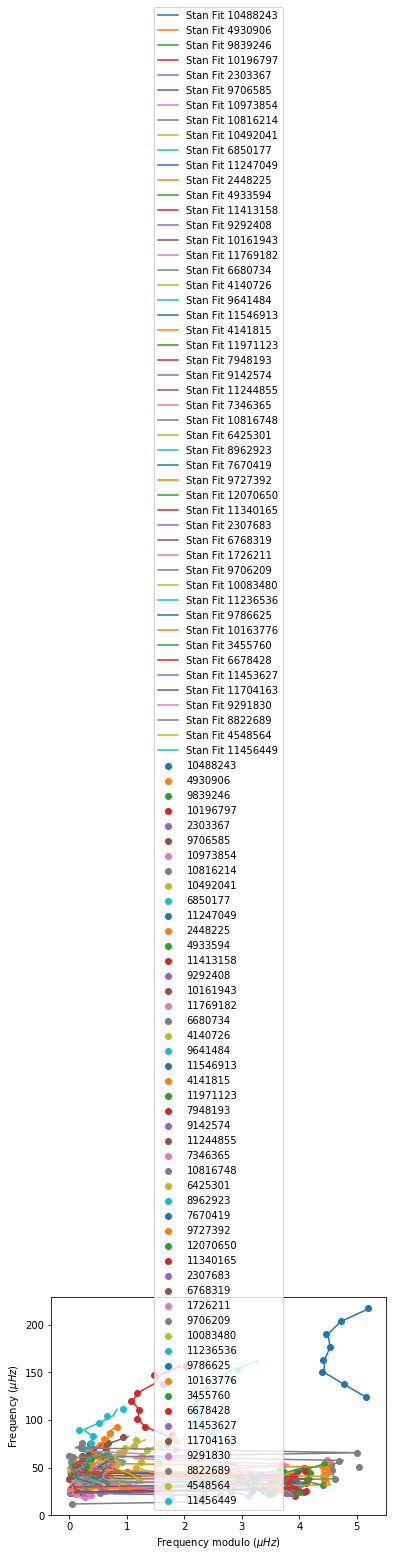

In [11]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['alpha'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['G'].mean(), fits[str(i)]['phi'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

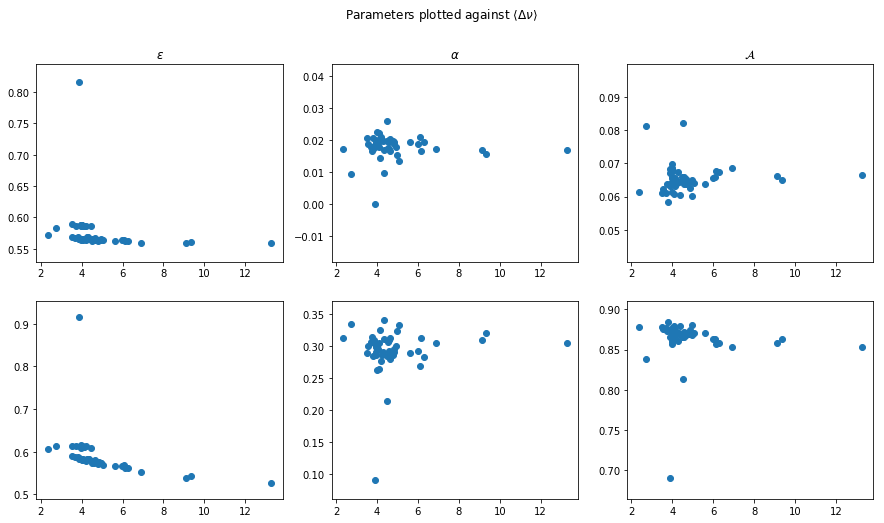

In [14]:
dnus = []
epsAs = []
epsBs = []
alAs = []
alBs = []
AAs = []
ABs = []
for i in IDs:
    dnus.append(fits[str(i)]['dnu'].mean())
    epsAs.append(fits[str(i)]['epsA'].mean())
    epsBs.append(fits[str(i)]['epsB'].mean())
    alAs.append(fits[str(i)]['alA'].mean())
    alBs.append(fits[str(i)]['alB'].mean())
    AAs.append(fits[str(i)]['AA'].mean())
    ABs.append(fits[str(i)]['AB'].mean())
    
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False)
axs[0,0].scatter(dnus, epsAs)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, epsBs)
#axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, alAs)
axs[0,1].set_title(r'$\alpha$')
axs[1,1].scatter(dnus, alBs)
#axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, AAs)
axs[0,2].set_title(r'$\mathcal{A}$')
axs[1,2].scatter(dnus, ABs)
#axs[1,2].set_title(r'$\mathcal{G}$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

In [ ]:
import corner
data = np.vstack([fit['dnu'], fit['nmax'], fit['epsilon'], fit['alpha'], fit['A'], fit['G'], fit['phi'], 
                fit['epsA'], fit['epsB'], fit['alA'], fit['alB'], fit['AA'], fit['AB']]).T
corner.corner(data, labels=['dnu', 'nmax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'epsA', 'epsB', 'alA', 'alB', 'AA', 'AB'])
plt.show()